# 전처리

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.ops import unary_union
from shapely.geometry import box
from shapely.strtree import STRtree
from shapely.geometry.base import BaseGeometry
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib
from shapely.geometry import Point
from pyproj import Transformer
from shapely.ops import transform
from tqdm import tqdm
import ast
import folium
from shapely.affinity import translate
import requests
import re
from shapely.ops import nearest_points
from itertools import product
import os
from collections import defaultdict
import json
import time
from folium.features import GeoJsonTooltip
import branca.colormap as cm
from shapely.geometry import mapping as shapely_mapping
from bs4 import BeautifulSoup
from folium.plugins import MarkerCluster
from ast import literal_eval
from geopy.distance import geodesic
from shapely.geometry import shape
from folium import Choropleth, GeoJson
from folium.plugins import Fullscreen
import random
from math import radians, cos, sin, sqrt, atan2
from shapely.geometry import mapping
import glob
from haversine import haversine

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# 파일 로드
df = pd.read_csv("./서울시격자_202412_보간완료.csv")

# 아동인구 계산
df['아동인구'] = df['2024_0-4세'] + df['2024_5-9세']

# 총생활인구 계산
pop_cols = [col for col in df.columns if col.startswith("202412") and len(col) == 11]
df['총생활인구'] = df[pop_cols].mean(axis=1)

# 소득 보간
def impute_income(row):
    q4_income = row['2024_4Q_월평균소득']
    q4_spend = row['2024_4Q_총지출']
    q3_spend = row['2024_3Q_총지출']
    if pd.isna(q4_income) and not pd.isna(q3_spend) and not pd.isna(q4_spend):
        q3_income = row['2024_3Q_월평균소득']
        if not pd.isna(q3_income) and q3_spend != 0:
            return q3_income * (q4_spend / q3_spend)
    return q4_income

df['소득_보간'] = df.apply(impute_income, axis=1)
df['소득_log'] = np.log1p(df['소득_보간'])
df['총생활인구_log'] = np.log1p(df['총생활인구'])

# 시설 개수 처리
def count_items(x):
    try:
        parsed = ast.literal_eval(x)
        return len(parsed) if isinstance(parsed, list) else 0
    except:
        return 0

facility_cols = ['서울형공립키즈카페_정보', '인증제키즈카페_정보', '일반키즈카페_정보',
                 '유치원_초등학교_정보', '어린이집_정보', '지역아동센터_정보',
                 '키움센터_정보', '유흥시설_정보', '대중교통_정보']

for col in facility_cols:
    df[col.replace('_정보', '_수')] = df[col].apply(count_items)

# 유치원과 어린이집 분리 → 유아시설_수 재구성
def count_facility_type_partial(data, keyword):
    try:
        items = ast.literal_eval(data)
        return sum(1 for item in items if keyword in item.get('시설유형', ''))
    except:
        return 0

df['유치원_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '유치원'))
df['초등학교_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '초등학교'))
df['어린이집_수_교집합'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '어린이집'))
df['어린이집_수'] = df['어린이집_정보'].apply(count_items)
df['유아시설_수'] = df['유치원_수'] + df['어린이집_수'] + df['어린이집_수_교집합']

# 돌봄시설 = 지역아동센터 + 키움센터
df['돌봄시설_수'] = df['지역아동센터_수'] + df['키움센터_수']

# 분석 변수 정의 (인증제 키즈카페 제외, 초등학교 포함)
all_features = ['소득_log', '총생활인구_log', '아동인구', '유아시설_수',
                '돌봄시설_수', '초등학교_수', '유흥시설_수', '대중교통_수',
                '일반키즈카페_수']
target_col = '서울형공립키즈카페_수'

# 데이터프레임 필터
df_model = df[all_features + [target_col, 'grid_id', '행정동명']].copy()
df_model_filtered = df_model[(df_model['총생활인구_log'] > 0) & (df_model['아동인구'] > 0)]

# 정규화
log_vars = ['소득_log', '총생활인구_log']
scale_vars = [col for col in all_features if col not in log_vars]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model_filtered[scale_vars])
X_scaled_df = pd.DataFrame(X_scaled, columns=scale_vars, index=df_model_filtered.index)

# 최종 데이터셋 구성
X_final = pd.concat([df_model_filtered[log_vars], X_scaled_df], axis=1)
y = df_model_filtered[target_col]

# 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_final, y)

# 중요도 추출
importance_final = pd.DataFrame({
    '변수': X_final.columns,
    '중요도': model.feature_importances_
}).sort_values(by='중요도', ascending=False).reset_index(drop=True)

importance_final

,변수,중요도
0,총생활인구_log,0.255454
1,소득_log,0.206633
2,아동인구,0.166510
3,대중교통_수,0.134369
4,유아시설_수,0.093576
5,돌봄시설_수,0.052944
6,일반키즈카페_수,0.037698
7,초등학교_수,0.026821
8,유흥시설_수,0.025994


# 선형회귀 - 돌리면 안된다 / 선형성 위배

# 비선형 회귀 - 랜덤포레스트

In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# 파일 로드
df = pd.read_csv("./서울시격자_202412_보간완료.csv")

# 아동인구 계산
df['아동인구'] = df['2024_0-4세'] + df['2024_5-9세']

# 총생활인구 계산
pop_cols = [col for col in df.columns if col.startswith("202412") and len(col) == 11]
df['총생활인구'] = df[pop_cols].mean(axis=1)

# 소득 보간
def impute_income(row):
    q4_income = row['2024_4Q_월평균소득']
    q4_spend = row['2024_4Q_총지출']
    q3_spend = row['2024_3Q_총지출']
    if pd.isna(q4_income) and not pd.isna(q3_spend) and not pd.isna(q4_spend):
        q3_income = row['2024_3Q_월평균소득']
        if not pd.isna(q3_income) and q3_spend != 0:
            return q3_income * (q4_spend / q3_spend)
    return q4_income

df['소득_보간'] = df.apply(impute_income, axis=1)
df['소득_log'] = np.log1p(df['소득_보간'])
df['총생활인구_log'] = np.log1p(df['총생활인구'])

# 시설 개수 처리
def count_items(x):
    try:
        parsed = ast.literal_eval(x)
        return len(parsed) if isinstance(parsed, list) else 0
    except:
        return 0

facility_cols = ['서울형공립키즈카페_정보', '일반키즈카페_정보',
                 '유치원_초등학교_정보', '어린이집_정보', '지역아동센터_정보',
                 '키움센터_정보', '유흥시설_정보', '대중교통_정보']

for col in facility_cols:
    df[col.replace('_정보', '_수')] = df[col].apply(count_items)

# 유아시설 수 계산
def count_facility_type_partial(data, keyword):
    try:
        items = ast.literal_eval(data)
        return sum(1 for item in items if keyword in item.get('시설유형', ''))
    except:
        return 0

df['유치원_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '유치원'))
df['초등학교_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '초등학교'))
df['어린이집_수_교집합'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '어린이집'))
df['어린이집_수'] = df['어린이집_정보'].apply(count_items)
df['유아시설_수'] = df['유치원_수'] + df['어린이집_수'] + df['어린이집_수_교집합']

# 돌봄시설 수 = 지역아동센터 + 키움센터
df['돌봄시설_수'] = df['지역아동센터_수'] + df['키움센터_수']

# 분석 변수 정의 (인증제 키즈카페 제외, 초등학교 포함)
all_features = ['소득_log', '총생활인구_log', '아동인구', '유아시설_수',
                '돌봄시설_수', '초등학교_수', '유흥시설_수', '대중교통_수',
                '일반키즈카페_수']
target_col = '서울형공립키즈카페_수'

# 데이터프레임 필터
df_model = df[all_features + [target_col, 'grid_id', '행정동명']].copy()
df_model_filtered = df_model[(df_model['총생활인구_log'] > 0) & (df_model['아동인구'] > 0)]

# 정규화
log_vars = ['소득_log', '총생활인구_log']
scale_vars = [col for col in all_features if col not in log_vars]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model_filtered[scale_vars])
X_scaled_df = pd.DataFrame(X_scaled, columns=scale_vars, index=df_model_filtered.index)

# 최종 데이터셋 구성
X_final = pd.concat([df_model_filtered[log_vars], X_scaled_df], axis=1)
y = df_model_filtered[target_col]

# 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_final, y)

# 중요도 추출
importance_final = pd.DataFrame({
    '변수': X_final.columns,
    '중요도': model.feature_importances_
}).sort_values(by='중요도', ascending=False).reset_index(drop=True)

importance_final

,변수,중요도
0,총생활인구_log,0.255454
1,소득_log,0.206633
2,아동인구,0.166510
3,대중교통_수,0.134369
4,유아시설_수,0.093576
5,돌봄시설_수,0.052944
6,일반키즈카페_수,0.037698
7,초등학교_수,0.026821
8,유흥시설_수,0.025994


# 랜덤포레스트 SHAP값

,변수,SHAP_영향력_평균
0,유아시설_수,0.022351
1,대중교통_수,0.012871
2,소득_log,0.011489
3,총생활인구_log,0.010753
4,아동인구,0.008495
5,돌봄시설_수,0.006660
6,일반키즈카페_수,0.005093
7,초등학교_수,0.003027
8,유흥시설_수,0.002650


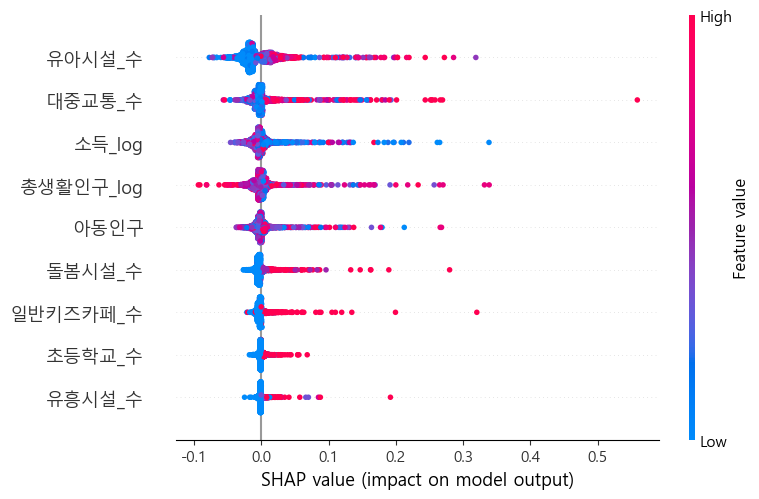

In [6]:
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   
plt.rcParams['axes.unicode_minus'] = False      

# TreeExplainer로 SHAP 값 계산 (랜덤포레스트 전용)
explainer_rf = shap.TreeExplainer(model)
shap_values_rf = explainer_rf.shap_values(X_final)

# 변수별 평균 영향력 계산
shap_rf_summary = pd.DataFrame({
    '변수': X_final.columns,
    'SHAP_영향력_평균': np.abs(shap_values_rf).mean(axis=0)
}).sort_values(by='SHAP_영향력_평균', ascending=False).reset_index(drop=True)

display(shap_rf_summary)
shap.summary_plot(shap_values_rf, X_final, feature_names=X_final.columns)

# XGBoost + SHAP

,변수,SHAP_영향력_평균
0,유아시설_수,0.022744
1,소득_log,0.018495
2,대중교통_수,0.017207
3,총생활인구_log,0.016923
4,아동인구,0.015397
5,돌봄시설_수,0.007404
6,일반키즈카페_수,0.005783
7,초등학교_수,0.003655
8,유흥시설_수,0.002657


,변수,중요도
0,유아시설_수,0.140885
1,일반키즈카페_수,0.122852
2,대중교통_수,0.122757
3,아동인구,0.120087
4,초등학교_수,0.114778
5,총생활인구_log,0.108449
6,소득_log,0.103560
7,돌봄시설_수,0.088924
8,유흥시설_수,0.077709


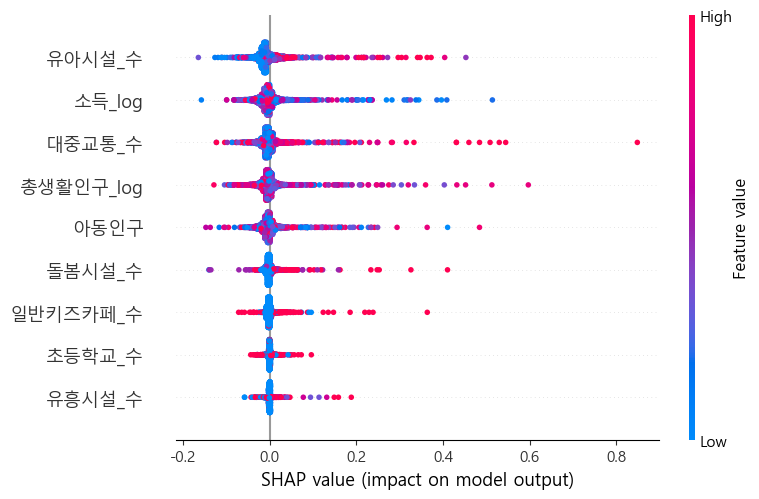

In [8]:
import pandas as pd
import numpy as np
import ast
import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False     

# 데이터 불러오기
df = pd.read_csv("./서울시격자_202412_보간완료.csv")

# 아동인구 계산
df['아동인구'] = df['2024_0-4세'] + df['2024_5-9세']

# 총생활인구 계산
pop_cols = [col for col in df.columns if col.startswith("202412") and len(col) == 11]
df['총생활인구'] = df[pop_cols].mean(axis=1)

# 소득 보간
def impute_income(row):
    q4_income = row['2024_4Q_월평균소득']
    q4_spend = row['2024_4Q_총지출']
    q3_spend = row['2024_3Q_총지출']
    if pd.isna(q4_income) and not pd.isna(q3_spend) and not pd.isna(q4_spend):
        q3_income = row['2024_3Q_월평균소득']
        if not pd.isna(q3_income) and q3_spend != 0:
            return q3_income * (q4_spend / q3_spend)
    return q4_income

df['소득_보간'] = df.apply(impute_income, axis=1)
df['소득_log'] = np.log1p(df['소득_보간'])
df['총생활인구_log'] = np.log1p(df['총생활인구'])

# 시설 개수 처리
def count_items(x):
    try:
        parsed = ast.literal_eval(x)
        return len(parsed) if isinstance(parsed, list) else 0
    except:
        return 0

facility_cols = ['서울형공립키즈카페_정보', '일반키즈카페_정보',
                 '유치원_초등학교_정보', '어린이집_정보', '지역아동센터_정보',
                 '키움센터_정보', '유흥시설_정보', '대중교통_정보']

for col in facility_cols:
    df[col.replace('_정보', '_수')] = df[col].apply(count_items)

# 유아시설 수 계산
def count_facility_type_partial(data, keyword):
    try:
        items = ast.literal_eval(data)
        return sum(1 for item in items if keyword in item.get('시설유형', ''))
    except:
        return 0

df['유치원_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '유치원'))
df['초등학교_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '초등학교'))
df['어린이집_수_교집합'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '어린이집'))
df['어린이집_수'] = df['어린이집_정보'].apply(count_items)
df['유아시설_수'] = df['유치원_수'] + df['어린이집_수'] + df['어린이집_수_교집합']

# 돌봄시설 수 계산
df['돌봄시설_수'] = df['지역아동센터_수'] + df['키움센터_수']

# 최종 변수 설정
features = ['소득_log', '총생활인구_log', '아동인구', '유아시설_수',
            '돌봄시설_수', '초등학교_수', '유흥시설_수', '대중교통_수',
            '일반키즈카페_수']
target = '서울형공립키즈카페_수'

df_model = df[features + [target]].copy()
df_model = df_model[(df_model['총생활인구_log'] > 0) & (df_model['아동인구'] > 0)]

# 정규화
log_vars = ['소득_log', '총생활인구_log']
scale_vars = [col for col in features if col not in log_vars]
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(df_model[scale_vars])
df_scaled = pd.DataFrame(scaled_vals, columns=scale_vars, index=df_model.index)
X = pd.concat([df_model[log_vars], df_scaled], axis=1)
y = df_model[target]

# 모델 학습
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP 분석
explainer = shap.Explainer(model)
shap_values = explainer(X)

# SHAP 평균 영향력 테이블
shap_summary_df = pd.DataFrame({
    '변수': X.columns,
    'SHAP_영향력_평균': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='SHAP_영향력_평균', ascending=False).reset_index(drop=True)

# XGBoost 중요도 테이블
xgb_importance_df = pd.DataFrame({
    '변수': X.columns,
    '중요도': model.feature_importances_
}).sort_values(by='중요도', ascending=False).reset_index(drop=True)

display(shap_summary_df)
display(xgb_importance_df)

shap.summary_plot(shap_values.values, X, plot_type="dot", show=True)

# Kmeans 군집분석 기반

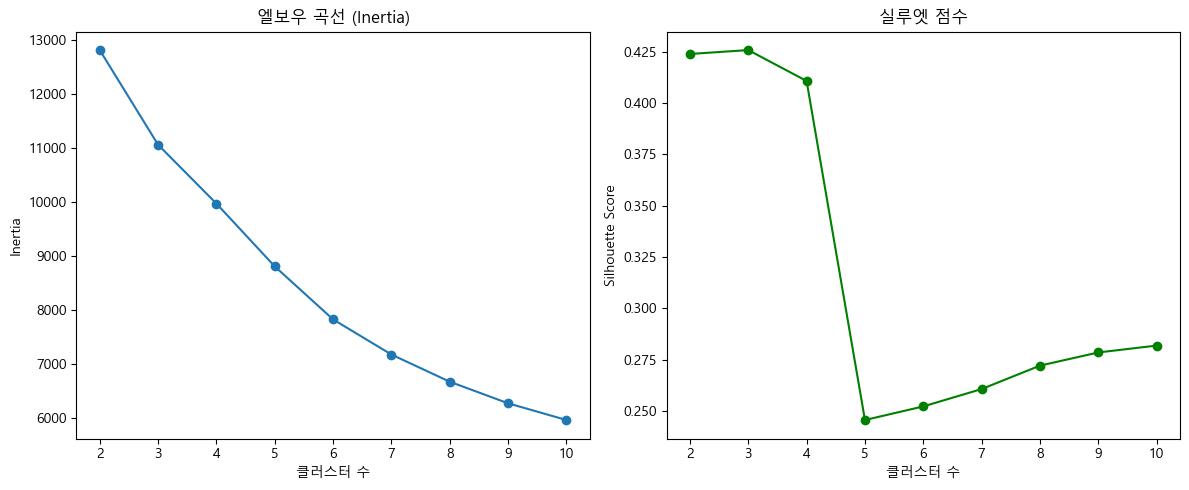

In [10]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("./서울시격자_202412_보간완료.csv")

# 아동인구 계산
df['아동인구'] = df['2024_0-4세'] + df['2024_5-9세']

# 총생활인구 계산
pop_cols = [col for col in df.columns if col.startswith("202412") and len(col) == 11]
df['총생활인구'] = df[pop_cols].mean(axis=1)

# 소득 보간
def impute_income(row):
    q4_income = row['2024_4Q_월평균소득']
    q4_spend = row['2024_4Q_총지출']
    q3_spend = row['2024_3Q_총지출']
    if pd.isna(q4_income) and not pd.isna(q3_spend) and not pd.isna(q4_spend):
        q3_income = row['2024_3Q_월평균소득']
        if not pd.isna(q3_income) and q3_spend != 0:
            return q3_income * (q4_spend / q3_spend)
    return q4_income

df['소득_보간'] = df.apply(impute_income, axis=1)
df['소득_log'] = np.log1p(df['소득_보간'])
df['총생활인구_log'] = np.log1p(df['총생활인구'])

# 시설 수 처리
def count_items(x):
    try:
        parsed = ast.literal_eval(x)
        return len(parsed) if isinstance(parsed, list) else 0
    except:
        return 0

facility_cols = ['서울형공립키즈카페_정보', '일반키즈카페_정보',
                 '유치원_초등학교_정보', '어린이집_정보', '지역아동센터_정보',
                 '키움센터_정보', '유흥시설_정보', '대중교통_정보']

for col in facility_cols:
    df[col.replace('_정보', '_수')] = df[col].apply(count_items)

# 유아시설 수 계산
def count_facility_type_partial(data, keyword):
    try:
        items = ast.literal_eval(data)
        return sum(1 for item in items if keyword in item.get('시설유형', ''))
    except:
        return 0

df['유치원_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '유치원'))
df['초등학교_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '초등학교'))
df['어린이집_수_교집합'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '어린이집'))
df['어린이집_수'] = df['어린이집_정보'].apply(count_items)
df['유아시설_수'] = df['유치원_수'] + df['어린이집_수'] + df['어린이집_수_교집합']

# 돌봄시설 수 계산
df['돌봄시설_수'] = df['지역아동센터_수'] + df['키움센터_수']

# 분석용 변수 설정 (인증제 제외, 초등학교 포함)
features = ['소득_log', '총생활인구_log', '아동인구', '서울형공립키즈카페_수',
            '유아시설_수', '돌봄시설_수', '초등학교_수',
            '유흥시설_수', '대중교통_수', '일반키즈카페_수']
df_model = df[features + ['grid_id', '행정동명']].copy()
df_model_filtered = df_model[(df_model['총생활인구_log'] > 0) & (df_model['아동인구'] > 0)].copy()

# 정규화
log_vars = ['소득_log', '총생활인구_log']
scale_vars = [col for col in features if col not in log_vars]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model_filtered[scale_vars])
X_scaled_df = pd.DataFrame(X_scaled, columns=scale_vars, index=df_model_filtered.index)
X_kmeans = pd.concat([df_model_filtered[log_vars], X_scaled_df], axis=1)

# KMeans 최적 클러스터 수 계산
inertias = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_kmeans)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_kmeans, kmeans.labels_))

# 결과 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow
ax[0].plot(cluster_range, inertias, marker='o')
ax[0].set_title('엘보우 곡선 (Inertia)')
ax[0].set_xlabel('클러스터 수')
ax[0].set_ylabel('Inertia')

# Silhouette
ax[1].plot(cluster_range, silhouette_scores, marker='o', color='green')
ax[1].set_title('실루엣 점수')
ax[1].set_xlabel('클러스터 수')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [11]:
# KMeans 클러스터링 (k=4) with 서울형 키즈카페 포함
kmeans_with_kids = KMeans(n_clusters=4, random_state=42, n_init=10)
df_model_filtered['클러스터'] = kmeans_with_kids.fit_predict(X_kmeans)

# 군집별 평균값 요약
cluster_summary_with_kids = df_model_filtered.groupby('클러스터')[X_kmeans.columns].mean().round(3)
cluster_summary_with_kids

,소득_log,총생활인구_log,아동인구,서울형공립키즈카페_수,유아시설_수,돌봄시설_수,초등학교_수,유흥시설_수,대중교통_수,일반키즈카페_수
클러스터,,,,,,,,,,
0,15.025,8.380,222.973,0.000,0.924,0.092,0.090,0.288,2.973,0.046
1,14.996,8.465,262.767,1.067,5.317,0.867,0.633,0.517,11.883,0.383
2,15.021,8.489,300.042,0.000,6.403,1.083,0.919,0.570,12.936,0.254
3,14.995,8.738,276.404,0.000,5.101,0.416,0.607,8.270,12.393,2.034


가중치(변수 j) = ∑ [ (군집 j의 서울형 키카 평균) × (해당 군집의 변수 평균) ] / ∑ 서울형 키카 평균

In [12]:
# 군집별 변수 평균 (이미 존재하는 cluster_summary_with_kids 활용)
cluster_summary_with_kids_copy = cluster_summary_with_kids.copy()

# 변수 목록과 클러스터별 서울형 키즈카페 평균 추출
variables = [col for col in cluster_summary_with_kids.columns if col != '서울형공립키즈카페_수']
cluster_weights = cluster_summary_with_kids['서울형공립키즈카페_수']

# 각 변수별로 군집별 평균 × 클러스터 중요도 (서울형 키즈카페 수) 계산
weighted_scores = {}

for var in variables:
    weighted_scores[var] = np.sum(cluster_summary_with_kids[var] * cluster_weights)

# 전체를 1로 정규화한 가중치로 변환
total = sum(weighted_scores.values())
final_weights = {k: v / total for k, v in weighted_scores.items()}

# 결과 정리
kmeans_weight_df = pd.DataFrame({
    '변수': list(final_weights.keys()),
    '가중치(KMeans 기반)': list(final_weights.values())
}).sort_values(by='가중치(KMeans 기반)', ascending=False).reset_index(drop=True)

kmeans_weight_df

,변수,가중치(KMeans 기반)
0,아동인구,0.859199
1,소득_log,0.049034
2,대중교통_수,0.038855
3,총생활인구_log,0.027679
4,유아시설_수,0.017386
5,돌봄시설_수,0.002835
6,초등학교_수,0.002070
7,유흥시설_수,0.001690
8,일반키즈카페_수,0.001252


In [3]:
import pandas as pd

# 데이터 정의: SHAP 영향력 평균 (랜덤포레스트)
shap_rf = {
    '유아시설_수': 0.022744,
    '소득_log': 0.018495,
    '대중교통_수': 0.017207,
    '총생활인구_log': 0.016923,
    '아동인구': 0.015397,
    '돌봄시설_수': 0.007404,
    '일반키즈카페_수': 0.005783,
    '초등학교_수': 0.003655,
    '유흥시설_수': 0.002657
}

importance_rf = {
    '유아시설_수': 0.140885,
    '소득_log': 0.103560,
    '대중교통_수': 0.122757,
    '총생활인구_log': 0.108449,
    '아동인구': 0.120087,
    '돌봄시설_수': 0.088924,
    '일반키즈카페_수': 0.122852,
    '초등학교_수': 0.114778,
    '유흥시설_수': 0.077709
}

# 데이터 정의: SHAP 영향력 평균 (XGBoost)
shap_xgb = {
    '유아시설_수': 0.022351,
    '대중교통_수': 0.012871,
    '소득_log': 0.011489,
    '총생활인구_log': 0.010753,
    '아동인구': 0.008495,
    '돌봄시설_수': 0.006660,
    '일반키즈카페_수': 0.005093,
    '초등학교_수': 0.003027,
    '유흥시설_수': 0.002650
}

importance_xgb = {
    '총생활인구_log': 0.255454,
    '소득_log': 0.206633,
    '아동인구': 0.166510,
    '대중교통_수': 0.134369,
    '유아시설_수': 0.093576,
    '돌봄시설_수': 0.052944,
    '일반키즈카페_수': 0.037698,
    '초등학교_수': 0.026821,
    '유흥시설_수': 0.025994
}

# 변수 목록 통합
all_vars = list(shap_rf.keys())

# 7:3 비율의 중요도 가중 평균 계산
combined_rf = {v: 0.7 * importance_rf[v] + 0.3 * shap_rf[v] for v in all_vars}
combined_xgb = {v: 0.7 * importance_xgb[v] + 0.3 * shap_xgb[v] for v in all_vars}

# 최종 평균
final_avg = {v: np.mean([combined_rf[v], combined_xgb[v]]) for v in all_vars}

# 데이터프레임 정리
final_df = pd.DataFrame({
    '변수': all_vars,
    '랜덤포레스트_가중합': [combined_rf[v] for v in all_vars],
    'XGBoost_가중합': [combined_xgb[v] for v in all_vars],
    '최종_평균_가중치': [final_avg[v] for v in all_vars]
}).sort_values(by='최종_평균_가중치', ascending=False).reset_index(drop=True)

final_df

,변수,랜덤포레스트_가중합,XGBoost_가중합,최종_평균_가중치
0,총생활인구_log,0.080991,0.182044,0.131517
1,소득_log,0.078040,0.148090,0.113065
2,아동인구,0.088680,0.119105,0.103893
3,대중교통_수,0.091092,0.097920,0.094506
4,유아시설_수,0.105443,0.072208,0.088826
5,일반키즈카페_수,0.087731,0.027917,0.057824
6,돌봄시설_수,0.064468,0.039059,0.051763
7,초등학교_수,0.081441,0.019683,0.050562
8,유흥시설_수,0.055193,0.018991,0.037092


# 지리가중회귀분석 - 쓰면 안됨 / 자기 강화형 오류

# 가중치 기반 입지점수 산출

# flat 데이터값가져오기

In [4]:
import pandas as pd

# 데이터 정의
data = {
    '변수명': [
        '총생활인구_log', '소득_log', '일반키즈카페_개수', '유아시설_수',
        '아동인구_log', '키움센터_개수', '대중교통_수', '초등학교_수', '유흥시설_수'
    ],
    '정책_점수': [0.30, 0.10, 0.10, 0.25, 0.20, 0.05, 0.05, 0.15, 0.15],
    '랜덤포레스트_중요도': [0.1833, 0.1778, 0.1323, 0.1237, 0.1220, 0.1076, 0.0723, 0.0516, 0.0294]
}

# DataFrame 생성
df = pd.DataFrame(data)

# 평균 계산
df['평균_가중치'] = df[['정책_점수', '랜덤포레스트_중요도']].mean(axis=1)

# 방향성 반영 (소득_log, 유흥시설_수 → 음수로 변경)
df.loc[df['변수명'] == '소득_log', '평균_가중치'] *= -1
df.loc[df['변수명'] == '유흥시설_수', '평균_가중치'] *= -1

# 결과 정렬
df_sorted = df.sort_values(by='평균_가중치', ascending=False).reset_index(drop=True)
df_sorted

,변수명,정책_점수,랜덤포레스트_중요도,평균_가중치
0,총생활인구_log,0.30,0.1833,0.24165
1,유아시설_수,0.25,0.1237,0.18685
2,아동인구_log,0.20,0.1220,0.16100
3,일반키즈카페_개수,0.10,0.1323,0.11615
4,초등학교_수,0.15,0.0516,0.10080
5,키움센터_개수,0.05,0.1076,0.07880
6,대중교통_수,0.05,0.0723,0.06115
7,유흥시설_수,0.15,0.0294,-0.08970
8,소득_log,0.10,0.1778,-0.13890


In [5]:
# 정책+랜덤포레스트 기반 평균 가중치
policy_rf_avg = {
    '총생활인구_log': 0.24165,
    '유아시설_수': 0.18685,
    '아동인구_log': 0.16100,
    '일반키즈카페_수': 0.11615,
    '초등학교_수': 0.10080,
    '돌봄시설_수': 0.07880,  # 키움센터_개수로부터 확장
    '대중교통_수': 0.06115,
    '유흥시설_수': 0.08970,
    '소득_log': 0.13890
}

# 방금 계산된 SHAP+중요도 기반 최종 평균 가중치
model_avg = {
    '총생활인구_log': 0.186575,
    '유아시설_수': 0.137825,
    '아동인구': 0.132450,
    '일반키즈카페_수': 0.086975,
    '초등학교_수': 0.075700,
    '돌봄시설_수': 0.065300,
    '대중교통_수': 0.077825,
    '유흥시설_수': 0.026300,
    '소득_log': 0.012900
}

# 아동인구 변수명 매핑
merged_vars = [
    '총생활인구_log', '유아시설_수', '아동인구_log', '일반키즈카페_수', '초등학교_수',
    '돌봄시설_수', '대중교통_수', '유흥시설_수', '소득_log'
]

# 평균값 계산
final_avg = {}
for var in merged_vars:
    v1 = policy_rf_avg.get(var, 0)
    v2_key = var if var != '아동인구_log' else '아동인구'
    v2 = model_avg.get(v2_key, 0)
    avg = (v1 + v2) / 2
    # 방향성 조정
    if var in ['소득_log', '유흥시설_수']:
        avg *= -1
    final_avg[var] = avg

# 정규화
total_abs = sum(abs(v) for v in final_avg.values())
normalized = {k: v / total_abs for k, v in final_avg.items()}

# 정리
final_df = pd.DataFrame({
    '변수': list(final_avg.keys()),
    '최종_가중치(정책+모델 평균)': list(final_avg.values()),
    '정규화_가중치': [normalized[k] for k in final_avg.keys()]
}).sort_values(by='정규화_가중치', ascending=False).reset_index(drop=True)

final_df

,변수,최종_가중치(정책+모델 평균),정규화_가중치
0,총생활인구_log,0.214112,0.216620
1,유아시설_수,0.162337,0.164239
2,아동인구_log,0.146725,0.148443
3,일반키즈카페_수,0.101562,0.102752
4,초등학교_수,0.088250,0.089283
5,돌봄시설_수,0.072050,0.072894
6,대중교통_수,0.069488,0.070301
7,유흥시설_수,-0.058000,-0.058679
8,소득_log,-0.075900,-0.076789


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import ast

# 파일 로드
df = pd.read_csv("./서울시격자_202412_보간완료.csv", engine='python')

# 아동인구 계산
df['아동인구'] = df['2024_0-4세'] + df['2024_5-9세']
df['아동인구_log'] = np.log1p(df['아동인구'])

# 소득 보간 및 로그 변환
def impute_income(row):
    q4_income = row['2024_4Q_월평균소득']
    q4_spend = row['2024_4Q_총지출']
    q3_spend = row['2024_3Q_총지출']
    q3_income = row['2024_3Q_월평균소득']
    if pd.isna(q4_income) and not pd.isna(q3_income) and not pd.isna(q4_spend) and not pd.isna(q3_spend) and q3_spend != 0:
        return q3_income * (q4_spend / q3_spend)
    return q4_income

df['2024_4Q_월평균소득_보간'] = df.apply(impute_income, axis=1)
df['소득_log'] = np.log1p(df['2024_4Q_월평균소득_보간'])

# 총생활인구 평균값 (12월)
pop_cols = [col for col in df.columns if col.startswith("202412") and len(col) == 11]
df['총생활인구'] = df[pop_cols].mean(axis=1)
df['총생활인구_log'] = np.log1p(df['총생활인구'])

# 리스트형 개수 처리
def count_items(x):
    try:
        parsed = ast.literal_eval(x)
        return len(parsed) if isinstance(parsed, list) else 0
    except:
        return 0

list_cols = {
    '어린이집_정보': '어린이집_수',
    '유치원_초등학교_정보': '유치원_초등학교_수',
    '키움센터_정보': '키움센터_수',
    '지역아동센터_정보': '지역아동센터_수',
    '일반키즈카페_정보': '일반키즈카페_수',
    '유흥시설_정보': '유흥시설_수',
    '대중교통_정보': '대중교통_수'
}
for col, new_col in list_cols.items():
    df[new_col] = df[col].apply(count_items)

# 유아시설 계산
def count_facility_type_partial(data, keyword):
    try:
        items = ast.literal_eval(data)
        return sum(1 for item in items if keyword in item.get('시설유형', ''))
    except:
        return 0

df['유치원_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '유치원'))
df['초등학교_수'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '초등학교'))
df['어린이집_수_교집합'] = df['유치원_초등학교_정보'].apply(lambda x: count_facility_type_partial(x, '어린이집'))
df['유아시설_수'] = df['유치원_수'] + df['어린이집_수'] + df['어린이집_수_교집합']
df['돌봄시설_수'] = df['지역아동센터_수'] + df['키움센터_수']

# ▶ 두 가지 가중치 버전
weights_raw = {
    '총생활인구_log': 0.214112,
    '유아시설_수': 0.162337,
    '아동인구_log': 0.146725,
    '일반키즈카페_수': 0.101562,
    '초등학교_수': 0.088250,
    '돌봄시설_수': 0.072050,
    '대중교통_수': 0.069488,
    '유흥시설_수': -0.058000,
    '소득_log': -0.075900
}

weights_norm = {
    '총생활인구_log': 0.216620,
    '유아시설_수': 0.164239,
    '아동인구_log': 0.148443,
    '일반키즈카페_수': 0.102752,
    '초등학교_수': 0.089283,
    '돌봄시설_수': 0.072894,
    '대중교통_수': 0.070301,
    '유흥시설_수': -0.058679,
    '소득_log': -0.076789
}

# 정규화
score_vars = list(weights_raw.keys())
scaler = StandardScaler()
df_z = df.copy()
df_z[score_vars] = scaler.fit_transform(df_z[score_vars])

# 점수 계산
df_z['입지점수_최종가중치'] = sum(df_z[var] * weight for var, weight in weights_raw.items())
df_z['입지점수_정규화가중치'] = sum(df_z[var] * weight for var, weight in weights_norm.items())

# 저장
save_path = "./서울시격자_입지점수_최종가중치_2종포함.csv"
df_z.to_csv(save_path, index=False, encoding='utf-8')
save_path

'./서울시격자_입지점수_최종가중치_2종포함.csv'

In [7]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# 다시 불러오기
df = pd.read_csv("./서울시격자_입지점수_최종가중치_2종포함.csv", engine="python")

# 종속변수 생성
def has_public_cafe(x):
    try:
        items = eval(x)
        return 1 if isinstance(items, list) and len(items) > 0 else 0
    except:
        return 0

df['서울형공립키즈카페_유무'] = df['서울형공립키즈카페_정보'].apply(has_public_cafe)

# 독립변수 및 타겟
X = df[['입지점수_정규화가중치']]
y = df['서울형공립키즈카페_유무']

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 로지스틱 회귀
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

# 결과 정리
result = {
    '입지점수_정규화가중치': {
        '정확도': accuracy_score(y_test, pred),
        'AUC': roc_auc_score(y_test, prob),
        'ConfusionMatrix': confusion_matrix(y_test, pred).tolist()
    }
}

result

{'입지점수_정규화가중치': {'정확도': 0.7558299039780522,
  'AUC': 0.8156176869072547,
  'ConfusionMatrix': [[535, 171], [7, 16]]}}

### 랜덤포레스트 분류분석 -> 방어적 예측으로 실제 설치 장소 예측 실패

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

df_rf = df.copy()

# 종속변수 생성
df_rf['서울형공립키즈카페_유무'] = df_rf['서울형공립키즈카페_정보'].apply(
    lambda x: 1 if isinstance(x, str) and x.startswith("[") and len(eval(x)) > 0 else 0
)

# 독립변수: 하나의 컬럼만 사용
X = df_rf[['입지점수_정규화가중치']]
y = df_rf['서울형공립키즈카페_유무']

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤포레스트 모델 학습 및 예측
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
prob = rf.predict_proba(X_test)[:, 1]

# 결과 정리
rf_result = {
    "입지점수_정규화가중치": {
        "정확도": accuracy_score(y_test, pred),
        "AUC": roc_auc_score(y_test, prob),
        "ConfusionMatrix": confusion_matrix(y_test, pred).tolist(),
        "분류리포트": classification_report(y_test, pred, output_dict=True)
    }
}

rf_result

{'입지점수_정규화가중치': {'정확도': 0.9382716049382716,
  'AUC': 0.6433366178100751,
  'ConfusionMatrix': [[681, 25], [20, 3]],
  '분류리포트': {'0': {'precision': 0.9714693295292439,
    'recall': 0.9645892351274787,
    'f1-score': 0.9680170575692963,
    'support': 706.0},
   '1': {'precision': 0.10714285714285714,
    'recall': 0.13043478260869565,
    'f1-score': 0.11764705882352941,
    'support': 23.0},
   'accuracy': 0.9382716049382716,
   'macro avg': {'precision': 0.5393060933360505,
    'recall': 0.5475120088680872,
    'f1-score': 0.5428320581964129,
    'support': 729.0},
   'weighted avg': {'precision': 0.9441997700438023,
    'recall': 0.9382716049382716,
    'f1-score': 0.9411878257844506,
    'support': 729.0}}}}

### XGBoost -> 여전히 실제 예측장소 Poor

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# 1. 파일 로드 (정규화 가중치 포함 파일 사용)
df = pd.read_csv("./서울시격자_입지점수_최종가중치_2종포함.csv", engine='python')

# 2. 종속변수 생성 (서울형 키즈카페 유무)
df['서울형공립키즈카페_유무'] = df['서울형공립키즈카페_정보'].apply(
    lambda x: 1 if isinstance(x, str) and x.startswith("[") and len(eval(x)) > 0 else 0
)

# 3. 독립변수 및 타겟 설정
X = df[['입지점수_정규화가중치']]
y = df['서울형공립키즈카페_유무']

# 4. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. 클래스 불균형 비율 계산
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos

# 6. XGBClassifier - 클래스 weight 보정
model_weight = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                             scale_pos_weight=scale_pos_weight,
                             use_label_encoder=False, eval_metric='logloss', random_state=42)
model_weight.fit(X_train, y_train)
pred_weight = model_weight.predict(X_test)
prob_weight = model_weight.predict_proba(X_test)[:, 1]

# 7. SMOTE 적용 후 XGBClassifier
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

model_smote = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                            use_label_encoder=False, eval_metric='logloss', random_state=42)
model_smote.fit(X_train_sm, y_train_sm)
pred_smote = model_smote.predict(X_test)
prob_smote = model_smote.predict_proba(X_test)[:, 1]

# 8. 결과 정리
xgb_results = {
    "입지점수_정규화가중치_XGB_weight": {
        "정확도": accuracy_score(y_test, pred_weight),
        "AUC": roc_auc_score(y_test, prob_weight),
        "ConfusionMatrix": confusion_matrix(y_test, pred_weight).tolist(),
        "분류리포트": classification_report(y_test, pred_weight, output_dict=True)
    },
    "입지점수_정규화가중치_XGB_SMOTE": {
        "정확도": accuracy_score(y_test, pred_smote),
        "AUC": roc_auc_score(y_test, prob_smote),
        "ConfusionMatrix": confusion_matrix(y_test, pred_smote).tolist(),
        "분류리포트": classification_report(y_test, pred_smote, output_dict=True)
    }
}

xgb_results

D:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:32:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:32:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'입지점수_정규화가중치_XGB_weight': {'정확도': 0.8299039780521262,
  'AUC': 0.772108634068235,
  'ConfusionMatrix': [[598, 108], [16, 7]],
  '분류리포트': {'0': {'precision': 0.9739413680781759,
    'recall': 0.8470254957507082,
    'f1-score': 0.906060606060606,
    'support': 706.0},
   '1': {'precision': 0.06086956521739131,
    'recall': 0.30434782608695654,
    'f1-score': 0.10144927536231885,
    'support': 23.0},
   'accuracy': 0.8299039780521262,
   'macro avg': {'precision': 0.5174054666477836,
    'recall': 0.5756866609188324,
    'f1-score': 0.5037549407114624,
    'support': 729.0},
   'weighted avg': {'precision': 0.9451338900729659,
    'recall': 0.8299039780521262,
    'f1-score': 0.8806750633911128,
    'support': 729.0}}},
 '입지점수_정규화가중치_XGB_SMOTE': {'정확도': 0.8120713305898491,
  'AUC': 0.7544032516319743,
  'ConfusionMatrix': [[580, 126], [11, 12]],
  '분류리포트': {'0': {'precision': 0.9813874788494078,
    'recall': 0.8215297450424929,
    'f1-score': 0.8943716268311488,
    'support': 706

### 보팅 앙상블 모형

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd

# 데이터 로드
df = pd.read_csv("./서울시격자_입지점수_최종가중치_2종포함.csv", engine="python")

# 종속변수 생성
df['서울형공립키즈카페_유무'] = df['서울형공립키즈카페_정보'].apply(
    lambda x: 1 if isinstance(x, str) and x.startswith("[") and len(eval(x)) > 0 else 0
)

# 클래스 불균형 비율 계산
n_pos = df['서울형공립키즈카페_유무'].sum()
n_neg = len(df) - n_pos
scale_pos_weight = n_neg / n_pos

# 모델 정의
logi = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

ensemble_clf = VotingClassifier(
    estimators=[('logi', logi), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# 독립변수 및 타겟
X = df[['입지점수_정규화가중치']]
y = df['서울형공립키즈카페_유무']

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 학습 및 예측
ensemble_clf.fit(X_train, y_train)
pred = ensemble_clf.predict(X_test)
prob = ensemble_clf.predict_proba(X_test)[:, 1]

# 평가 결과
voting_result = {
    "입지점수_정규화가중치_Voting": {
        "정확도": accuracy_score(y_test, pred),
        "AUC": roc_auc_score(y_test, prob),
        "ConfusionMatrix": confusion_matrix(y_test, pred).tolist(),
        "분류리포트": classification_report(y_test, pred, output_dict=True)
    }
}

voting_result

C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'입지점수_정규화가중치_Voting': {'정확도': 0.8902606310013718,
  'AUC': 0.8001601182411627,
  'ConfusionMatrix': [[643, 63], [17, 6]],
  '분류리포트': {'0': {'precision': 0.9742424242424242,
    'recall': 0.9107648725212465,
    'f1-score': 0.9414348462664714,
    'support': 706.0},
   '1': {'precision': 0.08695652173913043,
    'recall': 0.2608695652173913,
    'f1-score': 0.13043478260869565,
    'support': 23.0},
   'accuracy': 0.8902606310013718,
   'macro avg': {'precision': 0.5305994729907774,
    'recall': 0.5858172188693189,
    'f1-score': 0.5359348144375835,
    'support': 729.0},
   'weighted avg': {'precision': 0.9462484931620735,
    'recall': 0.8902606310013718,
    'f1-score': 0.9158477386339215,
    'support': 729.0}}}}

### 최적의 Threshold 찾기

In [50]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for t in thresholds:
    pred_t = (prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, pred_t))
    precision_scores.append(precision_score(y_test, pred_t))
    recall_scores.append(recall_score(y_test, pred_t))

# 가장 높은 f1-score를 가지는 threshold 찾기
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"최적 threshold (f1-score 기준): {best_threshold:.2f}")
print(f"F1: {f1_scores[best_idx]:.4f}, Precision: {precision_scores[best_idx]:.4f}, Recall: {recall_scores[best_idx]:.4f}")

최적 threshold (f1-score 기준): 0.49
F1: 0.1569, Precision: 0.1013, Recall: 0.3478


D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Prec

### 앙상블 모형 predict_proba 값으로 Top_N 값 뽑기

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# 파일 불러오기
df_z = pd.read_csv("./서울시격자_입지점수_최종가중치_2종포함.csv", engine='python')
df_rf_result = df_z.copy()

# 종속변수 생성
df_rf_result['서울형공립키즈카페_유무'] = df_rf_result['서울형공립키즈카페_정보'].apply(
    lambda x: 1 if isinstance(x, str) and x.startswith("[") and len(eval(x)) > 0 else 0
)

# 독립변수와 타겟
X = df_rf_result[['입지점수_정규화가중치']]
y = df_rf_result['서울형공립키즈카페_유무']

# 예측 대상: 미설치 격자만
X_no = df_rf_result[df_rf_result['서울형공립키즈카페_유무'] == 0][['입지점수_정규화가중치']]
idx_no = X_no.index

# 클래스 불균형 대비
n_pos = y.sum()
n_neg = len(y) - n_pos
scale_pos_weight = n_neg / n_pos

# 앙상블 모델 구성 (SMOTE 없이)
logi = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4,
                    scale_pos_weight=scale_pos_weight, use_label_encoder=False,
                    eval_metric='logloss', random_state=42)

ensemble_nominal = VotingClassifier(
    estimators=[('logi', logi), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# 모델 학습
ensemble_nominal.fit(X, y)

# 예측 확률
proba_nominal = ensemble_nominal.predict_proba(X_no)[:, 1]

# 결과 컬럼 저장 (확률)
df_rf_result['predict_proba_XGB_RF_nominal_정규화가중치기반'] = np.nan
df_rf_result.loc[idx_no, 'predict_proba_XGB_RF_nominal_정규화가중치기반'] = proba_nominal

# threshold 0.3 적용한 이진 예측 결과도 추가
threshold = 0.3
predict_nominal_03 = (proba_nominal >= threshold).astype(int)
df_rf_result['predict_binary_XGB_RF_nominal_정규화가중치기반_0.3'] = np.nan
df_rf_result.loc[idx_no, 'predict_binary_XGB_RF_nominal_정규화가중치기반_0.3'] = predict_nominal_03

# 저장 (덮어쓰기)
save_path = "./서울시격자_예측확률_정규화가중치기반.csv"
df_rf_result.to_csv(save_path, index=False, encoding='utf-8')
save_path

C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


'./서울시격자_예측확률_정규화가중치기반.csv'

In [13]:
df_rf_result.sort_values('predict_proba_XGB_RF_nominal_정규화가중치기반', ascending=False)[['행정동명', 'predict_proba_XGB_RF_nominal_정규화가중치기반']][:30]

,행정동명,predict_proba_XGB_RF_nominal_정규화가중치기반
1349,양재1동,0.684575
96,오류2동,0.683871
166,화곡8동,0.671116
2178,신내1동,0.670080
23,방화2동,0.667279
743,청룡동,0.660119
2107,공릉2동,0.659851
2208,송파1동,0.659729
1633,전농1동,0.655718
1323,삼양동,0.650913


### 테스트용 전체 격자 대상 predict_proba 값

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# 파일 불러오기
df_z = pd.read_csv("./서울시격자_입지점수_최종가중치_2종포함.csv", engine='python')
df_rf_result = df_z.copy()

# 종속변수 생성
df_rf_result['서울형공립키즈카페_유무'] = df_rf_result['서울형공립키즈카페_정보'].apply(
    lambda x: 1 if isinstance(x, str) and x.startswith("[") and len(eval(x)) > 0 else 0
)

# 독립변수와 타겟
X = df_rf_result[['입지점수_정규화가중치']]
y = df_rf_result['서울형공립키즈카페_유무']

# 클래스 불균형 보정
n_pos = y.sum()
n_neg = len(y) - n_pos
scale_pos_weight = n_neg / n_pos

# 앙상블 모델 구성
logi = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4,
                    scale_pos_weight=scale_pos_weight, use_label_encoder=False,
                    eval_metric='logloss', random_state=42)

ensemble_nominal = VotingClassifier(
    estimators=[('logi', logi), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# 모델 학습
ensemble_nominal.fit(X, y)

# 전체 예측 확률
df_rf_result['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'] = ensemble_nominal.predict_proba(X)[:, 1]

# threshold=0.3 적용 이진 예측
threshold = 0.3
df_rf_result['predict_binary_XGB_RF_nominal_정규화가중치기반_0.3_전체포함'] = (
    df_rf_result['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'] >= threshold
).astype(int)

# 저장
save_path = "./서울시격자_예측확률_전체포함_정규화가중치기반.csv"
df_rf_result.to_csv(save_path, index=False, encoding='utf-8')
print("저장 완료:", save_path)

C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


저장 완료: ./서울시격자_예측확률_전체포함_정규화가중치기반.csv


In [17]:
df_rf_result.sort_values('predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함',ascending=False)['행정동명'].head(30)

1744      답십리1동
253         목1동
675        상도4동
1678       방학1동
1609     성수1가1동
1203        혜화동
851         흑석동
79         발산1동
1522        종암동
668        보라매동
1355       서초1동
1026        후암동
2408       고덕2동
886         천연동
1386    금호2·3가동
486       신대방1동
1688       도봉2동
2280       성내1동
804        홍제3동
1669        창1동
2418      상일제2동
1662        번3동
212        화곡4동
2002       공릉1동
750        상도2동
316         상암동
850        상도1동
472         난향동
945        한강로동
2333       암사1동
Name: 행정동명, dtype: object

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import folium
import branca.colormap as cm

# 데이터 불러오기
df = pd.read_csv('./서울시격자_예측확률_정규화가중치기반.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# 예측 확률 컬럼
score_col = 'predict_proba_XGB_RF_nominal_정규화가중치기반'

# NaN을 최소값으로 대체
min_score = gdf[score_col].min(skipna=True)
gdf[score_col] = gdf[score_col].fillna(min_score)

# 지도 중심 계산
center = gdf.geometry.centroid.unary_union.centroid
map_center = [center.y, center.x]

# 색상 맵 정의
colormap = cm.LinearColormap(
    colors=['blue', 'lightblue', 'yellow', 'orange', 'red'],
    vmin=min_score,
    vmax=gdf[score_col].max(),
    caption='서울형 키즈카페 설치 예측 확률 (정규화 가중치 기반)'
)

# 지도 생성
m = folium.Map(location=map_center, zoom_start=11, tiles='cartodbpositron')

# 격자 시각화
for _, row in gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, row=row: {
            'fillColor': colormap(row[score_col]),
            'color': 'black',
            'weight': 0.2,
            'fillOpacity': 0.6
        },
        tooltip=folium.Tooltip(
            f"격자 ID: {row['grid_id']}<br>"
            f"행정동: {row['행정동명']}<br>"
            f"설치확률: {row[score_col]:.3f}"
        )
    ).add_to(m)

# 범례 추가
colormap.add_to(m)

# 저장
m.save('./서울형키즈카페_설치예측확률지도.html')
print("전체 시각화 저장 완료")

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import folium
import branca.colormap as cm

# 데이터 불러오기 (전체 격자 포함)
df = pd.read_csv('./서울시격자_예측확률_정규화가중치기반.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# 예측 확률 컬럼
score_col = 'predict_binary_XGB_RF_nominal_정규화가중치기반_0.3'

# NaN을 최소값으로 대체 (색상 범위에 포함되도록)
min_score = gdf[score_col].min(skipna=True)
gdf[score_col] = gdf[score_col].fillna(min_score)

# 지도 중심 계산
center = gdf.geometry.centroid.unary_union.centroid
map_center = [center.y, center.x]

# 색상 맵 정의
colormap = cm.LinearColormap(
    colors=['blue', 'lightblue', 'yellow', 'orange', 'red'],
    vmin=min_score,
    vmax=gdf[score_col].max(),
    caption='서울형 키즈카페 설치 예측 확률 (정규화 가중치 기반_Threshold=0.3)'
)

# 지도 생성
m = folium.Map(location=map_center, zoom_start=11, tiles='cartodbpositron')

# 격자 시각화
for _, row in gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, row=row: {
            'fillColor': colormap(row[score_col]),
            'color': 'black',
            'weight': 0.2,
            'fillOpacity': 0.6
        },
        tooltip=folium.Tooltip(
            f"격자 ID: {row['grid_id']}<br>"
            f"행정동: {row['행정동명']}<br>"
            f"설치확률: {row[score_col]:.3f}"
        )
    ).add_to(m)

# 범례 추가
colormap.add_to(m)

# 저장
m.save('./서울형키즈카페_설치예측확률지도_0.3.html')
print("전체 시각화 저장 완료")

# Moran & LISA 기반 가능성 타진 -> 필요없을 것 같음

# predict_proba 값 기반 모델링 평가

In [ ]:
import pandas as pd

# 파일 불러오기
file_score = pd.read_csv("./서울시격자_입지점수_최종가중치_2종포함.csv")
file_proba_partial = pd.read_csv("./서울시격자_예측확률_정규화가중치기반.csv")
file_proba_all = pd.read_csv("./서울시격자_예측확률_전체포함_정규화가중치기반.csv")

# 시리즈 추출
series_partial_proba = file_proba_partial.set_index("grid_id")["predict_proba_XGB_RF_nominal_정규화가중치기반"]
series_all_proba = file_proba_all.set_index("grid_id")["predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함"]
series_partial_bin = file_proba_partial.set_index("grid_id")["predict_binary_XGB_RF_nominal_정규화가중치기반_0.3"]
series_all_bin = file_proba_all.set_index("grid_id")["predict_binary_XGB_RF_nominal_정규화가중치기반_0.3_전체포함"]

# 점수 기준 파일에 병합
file_score.set_index("grid_id", inplace=True)
file_score["predict_proba_XGB_RF_nominal_정규화가중치기반"] = series_partial_proba
file_score["predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함"] = series_all_proba
file_score["predict_binary_XGB_RF_nominal_정규화가중치기반_0.3"] = series_partial_bin
file_score["predict_binary_XGB_RF_nominal_정규화가중치기반_0.3_전체포함"] = series_all_bin
file_score.reset_index(inplace=True)

# 저장
save_path = "./서울시격자_입지점수_예측결과_이중버전.csv"
file_score.to_csv(save_path, index=False, encoding='utf-8')
print("저장 완료:", save_path)

# 5. 확인용 출력
file_score[
    ['grid_id',
     'predict_proba_XGB_RF_nominal_정규화가중치기반',
     'predict_binary_XGB_RF_nominal_정규화가중치기반_0.3',
     'predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함',
     'predict_binary_XGB_RF_nominal_정규화가중치기반_0.3_전체포함']
].head()

In [ ]:
import pandas as pd

# 파일 로드
file_path = "./서울시격자_입지점수_예측결과_이중버전.csv"
df = pd.read_csv(file_path)

# 설치된 키즈카페 있는 격자만 필터링
df['서울형공립키즈카페_정보'] = df['서울형공립키즈카페_정보'].astype(str)
df_has_kids_cafe = df[df['서울형공립키즈카페_정보'].str.len() > 10]

# 설치된 격자들의 예측확률 값 분포 확인
value_counts = df_has_kids_cafe['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'].value_counts(dropna=False)
print("설치된 격자의 예측확률 분포 (NaN 포함):")
print(value_counts)

# 예측결과에서 NaN인 설치 격자 확인
df_installed = df[df['서울형공립키즈카페_정보'].str.len() > 10]
missing = df_installed[df_installed['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'].isna()]
print(f"\n NaN인 설치 격자 수: {len(missing)}")
print(missing[['grid_id', '행정동명']])

# 누락된 grid_id가 어디서 빠졌는지 확인
# 전체 예측 확률 파일에서 누락 여부 확인
file_proba_all = pd.read_csv("./서울시격자_예측확률_전체포함_정규화가중치기반.csv")

installed_ids = set(df_installed['grid_id'])
proba_all_ids = set(file_proba_all['grid_id'])
missing_ids = installed_ids - proba_all_ids

print(f"\n 예측결과에서 누락된 설치 격자 수: {len(missing_ids)}")
print("누락된 grid_id 목록:", missing_ids)

In [26]:
import pandas as pd

# 1. 전체 예측결과 파일 불러오기 (정규화 기반)
file_proba_all = pd.read_csv("./서울시격자_예측확률_전체포함_정규화가중치기반.csv")

# 2. 예측 확률 시리즈 추출 및 병합
proba_all_series = file_proba_all.set_index("grid_id")["predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함"]

# 기준 데이터 (입지점수 포함된 마스터) 불러오기
file_score = pd.read_csv("./서울시격자_입지점수_예측결과_이중버전.csv")
file_score.set_index("grid_id", inplace=True)
file_score["predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함"] = proba_all_series
file_score.reset_index(inplace=True)

# 3. threshold=0.5 기준 이진 예측 생성
file_score['predict_label_정규화가중치기반_전체포함'] = (
    file_score['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'] >= 0.5
).astype(int)

# 4. 설치된 키즈카페가 있는 격자만 필터링
df_installed = file_score[file_score['서울형공립키즈카페_정보'].astype(str).str.len() > 10].copy()

# 5. 예측 결과 기준 분리
pred_1 = df_installed[df_installed['predict_label_정규화가중치기반_전체포함'] == 1]
pred_0 = df_installed[df_installed['predict_label_정규화가중치기반_전체포함'] == 0]

# 6. 요약 컬럼
columns_to_show = [
    'grid_id', '행정동명',
    'predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함',
    '입지점수_정규화가중치'
]
pred_1_summary = pred_1[columns_to_show]
pred_0_summary = pred_0[columns_to_show]

# 7. 결과 출력
pred_1_summary, pred_0_summary

(     grid_id   행정동명  predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함  입지점수_정규화가중치
 79    G_0080   발산1동                                    0.817552     1.446322
 124   G_0125   화곡3동                                    0.578678     0.126921
 193   G_0194   개봉1동                                    0.714213     0.645355
 212   G_0213   화곡4동                                    0.753501     0.725292
 245   G_0246   신정7동                                    0.655517     0.349945
 ...      ...    ...                                         ...          ...
 2183  G_2184   망우본동                                    0.617429     0.405958
 2280  G_2281   성내1동                                    0.782381     0.718625
 2333  G_2334   암사1동                                    0.732306     1.127133
 2408  G_2409   고덕2동                                    0.806284     1.224101
 2418  G_2419  상일제2동                                    0.760172     0.640808
 
 [61 rows x 4 columns],
 Empty DataFrame
 Columns: [grid_id, 행

### 스피어만 계수 찾기

In [48]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.stats import spearmanr
from fuzzywuzzy import fuzz
import ast
from tqdm import tqdm

# 예약 데이터 로드 및 전처리
reserve_df = pd.read_csv(r"G:\내 드라이브\DIMA\new프로젝트\예약현황\예약현황_보간완료.csv")

def convert_korean_date(date_str):
    try:
        date_str = date_str.replace("월", "-").replace(" ", "")
        if "일" in date_str:
            date_str = date_str.replace("일", "")
        return pd.to_datetime(f"2025-{date_str}", format="%Y-%m-%d")
    except:
        return pd.NaT

reserve_df['date_parsed'] = reserve_df['date'].astype(str).apply(convert_korean_date)
reserve_df['reservated_num'] = reserve_df['reservated_num'].apply(lambda x: max(x, 0) if pd.notnull(x) else 0)
reserve_df['numbers_status'] = reserve_df['numbers_status'].fillna('').str.lower()

def calc_reservation_rate_safe(row):
    try:
        if 'person' in row['numbers_status'] or '공용' in row['numbers_status'] or '개인' in row['numbers_status']:
            if pd.notnull(row['capacity_person']) and row['capacity_person'] > 0:
                return row['reservated_num'] / row['capacity_person']
        elif 'people' in row['numbers_status'] or '단체' in row['numbers_status']:
            if pd.notnull(row['capacity_people']) and row['capacity_people'] > 0:
                return row['reservated_num'] / row['capacity_people']
        return None
    except:
        return None

reserve_df['예약률'] = reserve_df.apply(calc_reservation_rate_safe, axis=1)

# 격자 데이터 로드 및 시설명 추출
grid_df = pd.read_csv("./서울시격자_입지점수_예측결과_이중버전.csv")
grid_df['서울형공립키즈카페_정보'] = grid_df['서울형공립키즈카페_정보'].astype(str)

def extract_names(x):
    try:
        items = ast.literal_eval(x)
        return [i['시설명'] for i in items if isinstance(i, dict) and '시설명' in i]
    except:
        return []

grid_df['시설명리스트'] = grid_df['서울형공립키즈카페_정보'].apply(extract_names)
grid_exploded = grid_df.explode('시설명리스트').dropna(subset=['시설명리스트'])

# 예약센터 이름과 격자 시설명 매칭
all_reservation_names = reserve_df['name'].dropna().unique()
name_pairs = []
for facility in grid_exploded['시설명리스트'].unique():
    best_match = None
    best_score = 0
    for candidate in all_reservation_names:
        score = fuzz.token_sort_ratio(facility, candidate)
        if score > best_score:
            best_match = candidate
            best_score = score
    if best_score >= 90:
        name_pairs.append({'시설명리스트': facility, '예약현황_매핑명': best_match})
    else:
        name_pairs.append({'시설명리스트': facility, '예약현황_매핑명': None})

match_df = pd.DataFrame(name_pairs)
grid_matched = pd.merge(grid_exploded, match_df, on='시설명리스트', how='left')

# 날짜 구간 분석
date_list = sorted(reserve_df['date_parsed'].dropna().unique())
results = []

for i in range(len(date_list)):
    for j in range(i + 25, len(date_list)):  # 최소 15일 이상 구간
        start_date = pd.to_datetime(date_list[i])
        end_date = pd.to_datetime(date_list[j])

        df_range = reserve_df[(reserve_df['date_parsed'] >= start_date) & (reserve_df['date_parsed'] <= end_date)]
        daily_avg = df_range.groupby(['date', 'session', 'name'])['예약률'].mean().reset_index()
        avg_reserve_rate = daily_avg.groupby('name')['예약률'].mean().reset_index()
        avg_reserve_rate.rename(columns={'예약률': '평균예약률'}, inplace=True)

        merged = pd.merge(grid_matched, avg_reserve_rate, left_on='예약현황_매핑명', right_on='name', how='left')
        comparison_df = merged[['시설명리스트', '평균예약률', 'predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함']].dropna()

        if len(comparison_df) >= 60:
            corr, pval = spearmanr(
                comparison_df['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'],
                comparison_df['평균예약률']
            )
            results.append({
                '시작일': start_date,
                '종료일': end_date,
                '일수': (end_date - start_date).days + 1,
                '샘플수': len(comparison_df),
                '스피어만 상관계수': round(corr, 4),
                'p-value': round(pval, 4)
            })

# 결과 정리
result_df = pd.DataFrame(results)
top10 = result_df.sort_values(by='스피어만 상관계수', ascending=False).head(10).reset_index(drop=True)
top10

,시작일,종료일,일수,샘플수,스피어만 상관계수,p-value
0,2025-04-01,2025-04-28,28,61,0.0118,0.9281
1,2025-04-02,2025-04-28,27,61,0.0106,0.9352
2,2025-04-03,2025-04-28,26,61,0.0089,0.9460
3,2025-04-01,2025-04-27,27,61,0.0058,0.9643
4,2025-04-02,2025-04-27,26,61,0.0030,0.9816
5,2025-04-01,2025-04-26,26,61,0.0028,0.9827


In [ ]:
from fuzzywuzzy import fuzz
import pandas as pd
import ast
from tqdm import tqdm

# 데이터 불러오기
grid_df = pd.read_csv("./서울시격자_입지점수_예측결과_이중버전.csv")
reserve_df = pd.read_csv(r"G:\내 드라이브\DIMA\new프로젝트\예약현황\예약현황_보간완료.csv")

# 격자 → 시설명 추출
def extract_names(x):
    try:
        items = ast.literal_eval(x)
        return [i['시설명'] for i in items if isinstance(i, dict) and '시설명' in i]
    except:
        return []

grid_df['시설명리스트'] = grid_df['서울형공립키즈카페_정보'].apply(extract_names)
grid_facilities = set(pd.Series([name for sublist in grid_df['시설명리스트'] for name in sublist]))

# 예약현황 → 시설명 추출
reserve_names = set(reserve_df['name'].dropna().unique())

# Fuzzy matching (score ≥ 90)
matched_pairs = []
for grid_name in tqdm(grid_facilities, desc="매칭 중"):
    best_match = None
    best_score = 0
    for reserve_name in reserve_names:
        score = fuzz.token_sort_ratio(grid_name, reserve_name)
        if score > best_score:
            best_match = reserve_name
            best_score = score
    if best_score >= 90:
        matched_pairs.append((grid_name, best_match, best_score))

matched_grid_names = {g for g, r, s in matched_pairs}

# 결과 요약
print("서울형 키즈카페 시설명 비교 요약")
print(f"- 격자데이터 내 시설 수: {len(grid_facilities)}")
print(f"- 예약현황 내 시설 수: {len(reserve_names)}")
print(f"- 매칭된 시설 수 (유사도 90 이상): {len(matched_grid_names)}")

# 매칭 리스트 보고 싶을 경우:
matched_df = pd.DataFrame(matched_pairs, columns=["격자_시설명", "예약현황_시설명", "유사도"])
matched_df.sort_values(by="유사도", ascending=False).head()

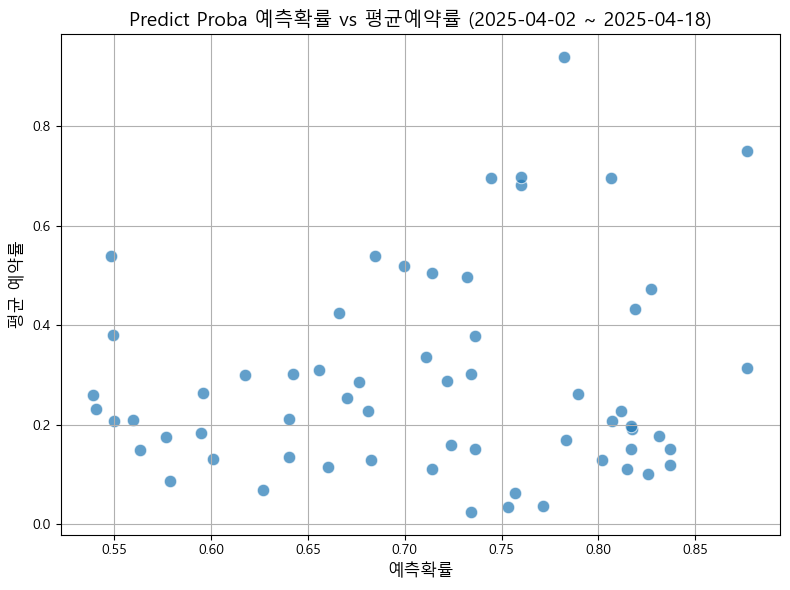

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 산점도: 입지점수 vs 평균예약률
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함',
    y='평균예약률',
    data=comparison_df,
    alpha=0.7,
    s=80
)
plt.title('Predict Proba 예측확률 vs 평균예약률 (2025-04-02 ~ 2025-04-18)', fontsize=14)
plt.xlabel('예측확률', fontsize=12)
plt.ylabel('평균 예약률', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# MCDA 값과 정규화 평균 & 정규화 곱으로 결합

In [84]:
# 전체 재정비 코드: 파일 로드 → 행정동명 정제 → 병합 → 정규화 → 점수계산 → 저장

from fuzzywuzzy import process

# 파일 로드
df_pred = pd.read_csv("./서울시격자_입지점수_예측결과_이중버전.csv")
df_mcda = pd.read_csv("./서울형키즈카페_MCDA결과_보완완료.csv")

# 2병합 실패한 행정동명 추출
test_merge = pd.merge(df_pred, df_mcda[['행정동명', 'MCDA_점수']], on='행정동명', how='left')
missing_dongs = test_merge[test_merge['MCDA_점수'].isna()]['행정동명'].unique().tolist()
mcda_dong_list = df_mcda['행정동명'].unique().tolist()

# 유사도 기반 행정동명 매핑
mapping_dict = {}
for name in missing_dongs:
    best_match, score = process.extractOne(name, mcda_dong_list)
    if score >= 85:
        mapping_dict[name] = best_match

# 정제된 행정동명으로 병합 준비
df_pred['행정동명_정제'] = df_pred['행정동명'].apply(lambda x: mapping_dict.get(x, x))
df_mcda['행정동명_정제'] = df_mcda['행정동명']

# 병합
df_merged = pd.merge(df_pred, df_mcda[['행정동명_정제', 'MCDA_점수']], on='행정동명_정제', how='left')

# 안전한 정규화 함수 정의
def minmax_normalize_safe(series):
    result = pd.Series(index=series.index, dtype='float64')
    notna = series.dropna()
    scaled = (notna - notna.min()) / (notna.max() - notna.min())
    result.loc[notna.index] = scaled
    return result

# 정규화 및 점수 계산
df_merged['MCDA_정규'] = minmax_normalize_safe(df_merged['MCDA_점수'])
df_merged['predict_정규'] = minmax_normalize_safe(df_merged['predict_proba_XGB_RF_nominal_정규화가중치기반'])
df_merged['predict_전체포함_정규'] = minmax_normalize_safe(df_merged['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'])

df_merged['정규화평균_제외'] = 0.5 * (df_merged['MCDA_정규'] + df_merged['predict_정규'])
df_merged['정규화곱_제외'] = df_merged['MCDA_정규'] * df_merged['predict_정규']
df_merged['정규화평균_전체'] = 0.5 * (df_merged['MCDA_정규'] + df_merged['predict_전체포함_정규'])
df_merged['정규화곱_전체'] = df_merged['MCDA_정규'] * df_merged['predict_전체포함_정규']

# 저장
final_path = "./서울시격자_입지점수_MCDA예측결합_전체포함.csv"
df_merged.to_csv(final_path, index=False)

final_path

'./서울시격자_입지점수_MCDA예측결합_전체포함.csv'

In [80]:
df_missing_mcda = df_merged[df_merged['MCDA_점수'].isna()][['grid_id', '행정동명']]
print(f"MCDA 점수가 누락된 격자 수: {len(df_missing_mcda)}")
print(df_missing_mcda.head(50))

MCDA 점수가 누락된 격자 수: 0
Empty DataFrame
Columns: [grid_id, 행정동명]
Index: []


In [86]:
file_path = "./서울시격자_입지점수_MCDA예측결합_전체포함.csv"
df = pd.read_csv(file_path)

df['서울형공립키즈카페_정보'] = df['서울형공립키즈카페_정보'].astype(str)
df_installed = df[df['서울형공립키즈카페_정보'].str.len() > 10]

# NaN 여부 확인: 정규화 컬럼 4종
na_check_cols = ['정규화평균_제외', '정규화곱_제외', '정규화평균_전체', '정규화곱_전체']
na_summary = df_installed[na_check_cols].isna().sum()

# 각 컬럼별 분포 확인 (정렬해서 보기 좋게)
distribution_summary = {}
for col in na_check_cols:
    distribution_summary[col] = df_installed[col].value_counts(dropna=False).sort_index()

# 누락된 행 출력
missing_rows = df_installed[df_installed[na_check_cols].isna().any(axis=1)][['grid_id', '행정동명'] + na_check_cols]

na_summary, distribution_summary, missing_rows.head(10)

(정규화평균_제외    61
 정규화곱_제외     61
 정규화평균_전체     0
 정규화곱_전체      0
 dtype: int64,
 {'정규화평균_제외': 정규화평균_제외
  NaN    61
  Name: count, dtype: int64,
  '정규화곱_제외': 정규화곱_제외
  NaN    61
  Name: count, dtype: int64,
  '정규화평균_전체': 정규화평균_전체
  0.480145    1
  0.507655    1
  0.511466    1
  0.524966    1
  0.528758    1
             ..
  0.785268    1
  0.814384    1
  0.815790    1
  0.823273    1
  0.849215    1
  Name: count, Length: 61, dtype: int64,
  '정규화곱_전체': 정규화곱_전체
  0.212564    1
  0.236917    1
  0.245977    1
  0.246699    1
  0.257903    1
             ..
  0.591540    1
  0.646593    1
  0.649560    1
  0.664974    1
  0.714319    1
  Name: count, Length: 61, dtype: int64},
     grid_id   행정동명  정규화평균_제외  정규화곱_제외  정규화평균_전체   정규화곱_전체
 79   G_0080   발산1동       NaN      NaN  0.849215  0.714319
 124  G_0125   화곡3동       NaN      NaN  0.524966  0.257903
 193  G_0194   개봉1동       NaN      NaN  0.699204  0.475840
 212  G_0213   화곡4동       NaN      NaN  0.627626  0.340616
 245  G_0246   신정7동  

In [ ]:
import pandas as pd

# 파일 로드 (MCDA + 예측결합 점수 포함된 최신 마스터 파일)
file_score = pd.read_csv("./서울시격자_입지점수_MCDA예측결합_전체포함.csv")

# 이진 예측 생성 (threshold 0.5 기준)
file_score['predict_label_전체포함'] = (
    file_score['predict_proba_XGB_RF_nominal_정규화가중치기반_전체포함'] >= 0.5
).astype(int)

# 설치된 키즈카페 있는 격자만 필터링
df_installed = file_score[file_score['서울형공립키즈카페_정보'].astype(str).str.len() > 10].copy()

# 예측 결과에 따라 분리
pred_1 = df_installed[df_installed['predict_label_전체포함'] == 1]
pred_0 = df_installed[df_installed['predict_label_전체포함'] == 0]

# 출력 컬럼 구성 (proba 제외, 평가용 목적 중심)
columns_to_show = [
    'grid_id', '행정동명',
    'predict_label_전체포함',
    '정규화평균_전체', '정규화곱_전체'
]

pred_1_summary = pred_1[columns_to_show]
pred_0_summary = pred_0[columns_to_show]

# 6. 결과 출력
print("예측 Label = 1 (설치 예측된 격자)")
print(pred_1_summary.head())

print("\n 예측 Label = 0 (설치 안된다고 예측한 격자)")
print(pred_0_summary.head())

In [90]:
# 전체 파일에서 설치 여부 기준 컬럼 생성
file_score['설치여부'] = (file_score['서울형공립키즈카페_정보'].astype(str).str.len() > 10).astype(int)

# 혼동행렬 계산
from sklearn.metrics import confusion_matrix, classification_report

y_true = file_score['설치여부']
y_pred = file_score['predict_label_전체포함']

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['미설치', '설치']))

[[2185  181]
 [   0   61]]
              precision    recall  f1-score   support

         미설치       1.00      0.92      0.96      2366
          설치       0.25      1.00      0.40        61

    accuracy                           0.93      2427
   macro avg       0.63      0.96      0.68      2427
weighted avg       0.98      0.93      0.95      2427



In [5]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.stats import spearmanr
from fuzzywuzzy import fuzz
import ast
from tqdm import tqdm

# 예약 데이터 로드 및 전처리
reserve_df = pd.read_csv(r"G:\내 드라이브\DIMA\new프로젝트\예약현황\예약현황_보간완료.csv")

def convert_korean_date(date_str):
    try:
        date_str = date_str.replace("월", "-").replace(" ", "")
        if "일" in date_str:
            date_str = date_str.replace("일", "")
        return pd.to_datetime(f"2025-{date_str}", format="%Y-%m-%d")
    except:
        return pd.NaT

reserve_df['date_parsed'] = reserve_df['date'].astype(str).apply(convert_korean_date)
reserve_df['reservated_num'] = reserve_df['reservated_num'].apply(lambda x: max(x, 0) if pd.notnull(x) else 0)
reserve_df['numbers_status'] = reserve_df['numbers_status'].fillna('').str.lower()

def calc_reservation_rate_safe(row):
    try:
        if 'person' in row['numbers_status'] or '공용' in row['numbers_status'] or '개인' in row['numbers_status']:
            if pd.notnull(row['capacity_person']) and row['capacity_person'] > 0:
                return row['reservated_num'] / row['capacity_person']
        elif 'people' in row['numbers_status'] or '단체' in row['numbers_status']:
            if pd.notnull(row['capacity_people']) and row['capacity_people'] > 0:
                return row['reservated_num'] / row['capacity_people']
        return None
    except:
        return None

reserve_df['예약률'] = reserve_df.apply(calc_reservation_rate_safe, axis=1)

# 격자 데이터 로드 및 시설명 추출
grid_df = pd.read_csv("./서울시격자_입지점수_MCDA예측결합_전체포함.csv")
grid_df['서울형공립키즈카페_정보'] = grid_df['서울형공립키즈카페_정보'].astype(str)

def extract_names(x):
    try:
        items = ast.literal_eval(x)
        return [i['시설명'] for i in items if isinstance(i, dict) and '시설명' in i]
    except:
        return []

grid_df['시설명리스트'] = grid_df['서울형공립키즈카페_정보'].apply(extract_names)
grid_exploded = grid_df.explode('시설명리스트').dropna(subset=['시설명리스트'])

# 예약센터 이름과 격자 시설명 매칭 (고정)
all_reservation_names = reserve_df['name'].dropna().unique()
name_pairs = []
for facility in grid_exploded['시설명리스트'].unique():
    best_match = None
    best_score = 0
    for candidate in all_reservation_names:
        score = fuzz.token_sort_ratio(facility, candidate)
        if score > best_score:
            best_match = candidate
            best_score = score
    if best_score >= 90:
        name_pairs.append({'시설명리스트': facility, '예약현황_매핑명': best_match})
    else:
        name_pairs.append({'시설명리스트': facility, '예약현황_매핑명': None})

match_df = pd.DataFrame(name_pairs)
grid_matched = pd.merge(grid_exploded, match_df, on='시설명리스트', how='left')

# 날짜 구간 분석 (정규화평균_전체 + 정규화곱_전체)
date_list = sorted(reserve_df['date_parsed'].dropna().unique())
results = []

for i in range(len(date_list)):
    for j in range(i + 25, len(date_list)):  # 최소 15일 이상 구간
        start_date = pd.to_datetime(date_list[i])
        end_date = pd.to_datetime(date_list[j])

        df_range = reserve_df[(reserve_df['date_parsed'] >= start_date) & (reserve_df['date_parsed'] <= end_date)]
        daily_avg = df_range.groupby(['date', 'session', 'name'])['예약률'].mean().reset_index()
        avg_reserve_rate = daily_avg.groupby('name')['예약률'].mean().reset_index()
        avg_reserve_rate.rename(columns={'예약률': '평균예약률'}, inplace=True)

        merged = pd.merge(grid_matched, avg_reserve_rate, left_on='예약현황_매핑명', right_on='name', how='left')

        for 기준컬럼 in ['정규화평균_전체', '정규화곱_전체']:
            comparison_df = merged[['시설명리스트', '평균예약률', 기준컬럼]].dropna()
            if len(comparison_df) >= 60:
                corr, pval = spearmanr(comparison_df[기준컬럼], comparison_df['평균예약률'])
                results.append({
                    '시작일': start_date,
                    '종료일': end_date,
                    '일수': (end_date - start_date).days + 1,
                    '샘플수': len(comparison_df),
                    '상관분석_기준': 기준컬럼,
                    '스피어만 상관계수': round(corr, 4),
                    'p-value': round(pval, 4)
                })

# 결과 정리
result_df = pd.DataFrame(results)
top10 = result_df.sort_values(by='스피어만 상관계수', ascending=False).head(10).reset_index(drop=True)
top10

C:\Users\user\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,시작일,종료일,일수,샘플수,상관분석_기준,스피어만 상관계수,p-value
0,2025-04-01,2025-04-28,28,61,정규화곱_전체,0.3097,0.0151
1,2025-04-01,2025-04-26,26,61,정규화곱_전체,0.3094,0.0153
2,2025-04-02,2025-04-28,27,61,정규화곱_전체,0.3066,0.0162
3,2025-04-03,2025-04-28,26,61,정규화곱_전체,0.3059,0.0165
4,2025-04-01,2025-04-27,27,61,정규화곱_전체,0.2976,0.0198
5,2025-04-02,2025-04-27,26,61,정규화곱_전체,0.2963,0.0204
6,2025-04-01,2025-04-28,28,61,정규화평균_전체,0.2445,0.0576
7,2025-04-01,2025-04-26,26,61,정규화평균_전체,0.2424,0.0598
8,2025-04-03,2025-04-28,26,61,정규화평균_전체,0.2402,0.0623
9,2025-04-02,2025-04-28,27,61,정규화평균_전체,0.2399,0.0625


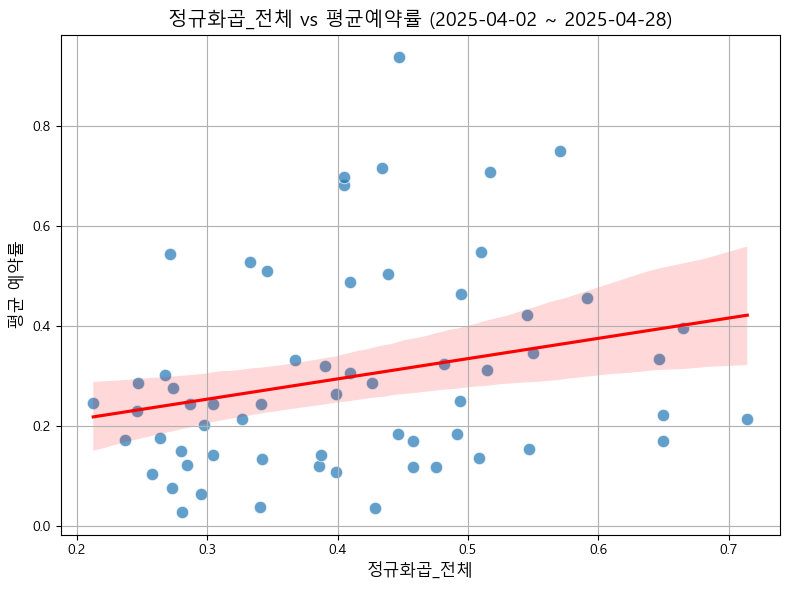

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 산점도: 입지점수 vs 평균예약률
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='정규화곱_전체',
    y='평균예약률',
    data=comparison_df,
    alpha=0.7,
    s=80
)
sns.regplot(x='정규화곱_전체', y='평균예약률', data=comparison_df, scatter=False, color='red')
plt.title('정규화곱_전체 vs 평균예약률 (2025-04-02 ~ 2025-04-28)', fontsize=14)
plt.xlabel('정규화곱_전체', fontsize=12)
plt.ylabel('평균 예약률', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# MCLP 모델 리스트 뽑기

In [110]:
from fuzzywuzzy import process
import pandas as pd

# 데이터 불러오기
mcda_df = pd.read_csv('./서울시격자_입지점수_MCDA예측결합_전체포함.csv')
mclp_df = pd.read_csv('./MCLP_추천결과_270개.csv')

# 기준이 될 행정동명 목록
mcda_dongs = mcda_df['행정동명'].dropna().unique().tolist()
mclp_dongs = mclp_df['grid_id'].dropna().unique().tolist()  # 실제는 행정동명임

# 유사도 매칭 결과 저장
matched = {}
for dong in mclp_dongs:
    best_match, score = process.extractOne(dong, mcda_dongs)
    if score >= 90:  # 유사도 기준 조절 가능
        matched[dong] = best_match

# 매칭된 행정동명 리스트
matched_dongs = list(set(matched.values()))
mcda_df['MCLP_추천여부'] = mcda_df['행정동명'].apply(lambda x: 1 if x in matched_dongs else 0)

# 교집합 여부 (MCDA 점수도 존재)
mcda_df['MCLP_MCDA_교집합여부'] = ((mcda_df['MCLP_추천여부'] == 1) & (~mcda_df['MCDA_점수'].isna())).astype(int)

# 저장
mcda_df.to_csv('./서울시격자_MCDA_MCLP_행정동매칭_결합완료.csv', index=False)

In [120]:
# 결합한 파일 다시 불러오기
merged_df = pd.read_csv("./서울시격자_MCDA_MCLP_행정동매칭_결합완료.csv")

# MCLP + MCDA 교집합 중에서
filtered = merged_df[merged_df['MCLP_MCDA_교집합여부'] == 1]

# 행정동명 기준으로 MCDA 점수 가장 높은 값만 남기기
top_dongs = (
    filtered.sort_values(by='MCDA_점수', ascending=False)
    .drop_duplicates(subset='행정동명', keep='first')
    [['행정동명', 'MCDA_점수']]
    .reset_index(drop=True)
)

# 상위 10개만 조회
top_dongs.head(20)

,행정동명,MCDA_점수
0,진관동,0.587229
1,독산1동,0.516695
2,양재1동,0.513226
3,여의동,0.508427
4,공릉2동,0.498254
5,신정3동,0.493920
6,오류2동,0.478712
7,방화1동,0.472586
8,위례동,0.468688
9,상암동,0.465825
